# Calculate density and velocity gradients

In [1]:
# Jupyter Notebook with widget matplotlib plots
#%matplotlib notebook
# Jupyter Lab with widget matplotlib plots
#%matplotlib widget 
# with Jupyter and Jupyter Lab but without widget matplotlib plots
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import sys
import pyicon as pyic
import cartopy
import seawater as sw

In [3]:
ccrs_proj = cartopy.crs.PlateCarree()

## Specify data set

In [4]:
run = 'nib0004'
runname = 'icon_08'
gname = 'r2b6'
lev = 'L64'

path_data     = f'/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/{runname}/icon-oes/experiments/{run}/'
path_grid     = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{gname}/'
path_ckdtree  = f'{path_grid}ckdtree/'
fpath_ckdtree = f'{path_grid}ckdtree/rectgrids/{gname}_res0.30_180W-180E_90S-90N.npz'
fpath_fx      = f'{path_grid}{gname}_{lev}_fx.nc'

In [5]:
IcD = pyic.IconData(
    fname        = run+'_????????????????.nc',
    path_data    = path_data,
    path_grid    = path_grid,
    gname        = gname,
    lev          = lev,
    do_triangulation    = True,
    omit_last_file      = False,
    calc_coeff          = True,
    calc_coeff_mappings = True,
              )

Start with calc_coeff...
Done with calc_coeff!
Start with calc_coeff_mappings...
--- fixed_vol_norm
--- edge2edge_viacell_coeff
--- edge2cell_coeff_cc
--- edge2cell_coeff_cc_t
Done with calc_coeff_mappings!


Define time frame for averaging (shorter time periods should be chosen for testing):

In [6]:
t1 = '2100-02-01'
t2 = '2150-01-01'

## Derive gradients

Load time averaged data

In [7]:
# --- load data
uo, it_ave   = pyic.time_average(IcD, 'u', t1=t1, t2=t2, iz='all')
vo, it_ave   = pyic.time_average(IcD, 'v', t1=t1, t2=t2, iz='all')
to, it_ave   = pyic.time_average(IcD, 'to', t1=t1, t2=t2, iz='all')
so, it_ave   = pyic.time_average(IcD, 'so', t1=t1, t2=t2, iz='all')

### Density gradients

Hor. density gradient is derived from potential density, therefore derive this first (we use buoyancy instead of density but this does not matter):

In [8]:
rho_pot = sw.dens(so, to, 0.)
b = -IcD.grav*(rho_pot-IcD.rho0)/IcD.rho0
# b = rho_pot-1000.
b[IcD.wet_c==0.] = np.ma.masked

Derive hor. density gradient:

In [9]:
gradh_b = (b[:,IcD.adjacent_cell_of_edge[:,1]]-b[:,IcD.adjacent_cell_of_edge[:,0]])*IcD.grad_coeff

The gradient is defined on edges. Now, we map this back to the center and convert the 3D vector into the conventional 2D vector in zon. and merid. direction.

In [10]:
p_gradh_b = pyic.edges2cell(IcD, gradh_b)
dbdx, dbdy = pyic.calc_2dlocal_from_3d(IcD, p_gradh_b)

Derive vertical density gradient (bouyancy frequency, $N^2$). The density values that go into the vertical density difference need to be referrenced to the same pressure value. Therefore derive them first:

In [11]:
rhop1 = sw.dens(so[1:,:], to[1:,:], IcD.depthi[1:-1,np.newaxis])
rhom1 = sw.dens(so[:-1,:], to[:-1,:], IcD.depthi[1:-1,np.newaxis])

In [12]:
N2 = np.ma.zeros((IcD.nz+1,to.shape[1]))
N2[1:-1,:] = - (rhom1-rhop1)/IcD.dzt[1:-1,:] * IcD.grav/IcD.rho0
N2[:-1,:] *= IcD.wet_c

N2 is defined on cell interface, no interpolate back to cell centers:

In [13]:
N2vi = 0.5*(N2[1:,:]+N2[:-1,:])
N2vi *= IcD.wet_c

### Velocity gradients

Same as for density:

In [14]:
gradh_u = (uo[:,IcD.adjacent_cell_of_edge[:,1]]-uo[:,IcD.adjacent_cell_of_edge[:,0]])*IcD.grad_coeff
gradh_v = (vo[:,IcD.adjacent_cell_of_edge[:,1]]-vo[:,IcD.adjacent_cell_of_edge[:,0]])*IcD.grad_coeff
p_gradh_u = pyic.edges2cell(IcD, gradh_u)
p_gradh_v = pyic.edges2cell(IcD, gradh_v)
dudx, dudy = pyic.calc_2dlocal_from_3d(IcD, p_gradh_u)
dvdx, dvdy = pyic.calc_2dlocal_from_3d(IcD, p_gradh_v)

We derive here the vertical gradient as simple centered differences. This is not totally accurate when the vert. grid spacing is uneven. Maybe this can be improved.

In [15]:
dudz = np.ma.zeros((IcD.nz+1,uo.shape[1]))
dudz[1:-1,:] = (uo[:-1,:]-uo[1:,:])/IcD.dzt[1:-1,:]
dudz[:-1,:] *= IcD.wet_c
dvdz = np.ma.zeros((IcD.nz+1,vo.shape[1]))
dvdz[1:-1,:] = (vo[:-1,:]-vo[1:,:])/IcD.dzt[1:-1,:]
dvdz[:-1,:] *= IcD.wet_c

Interplate back from interfaces to cell centers:

In [16]:
dudzvi = 0.5*(dudz[1:,:]+dudz[:-1,:])
dudzvi *= IcD.wet_c
dvdzvi = 0.5*(dvdz[1:,:]+dvdz[:-1,:])
dvdzvi *= IcD.wet_c

## Plot density gradients

For plotting interpolate everything to regular grid:

In [17]:
lon, lat, bi = pyic.interp_to_rectgrid(b, fpath_ckdtree, coordinates='clat clon')
lon, lat, dbdxi = pyic.interp_to_rectgrid(dbdx, fpath_ckdtree, coordinates='clat clon')
lon, lat, dbdyi = pyic.interp_to_rectgrid(dbdy, fpath_ckdtree, coordinates='clat clon')
lon, lat, N2vihi = pyic.interp_to_rectgrid(N2vi, fpath_ckdtree, coordinates='clat clon')

Choose depth level:

In [18]:
iz = np.argmin((IcD.depthc-300.)**2)

Horizontal plots:

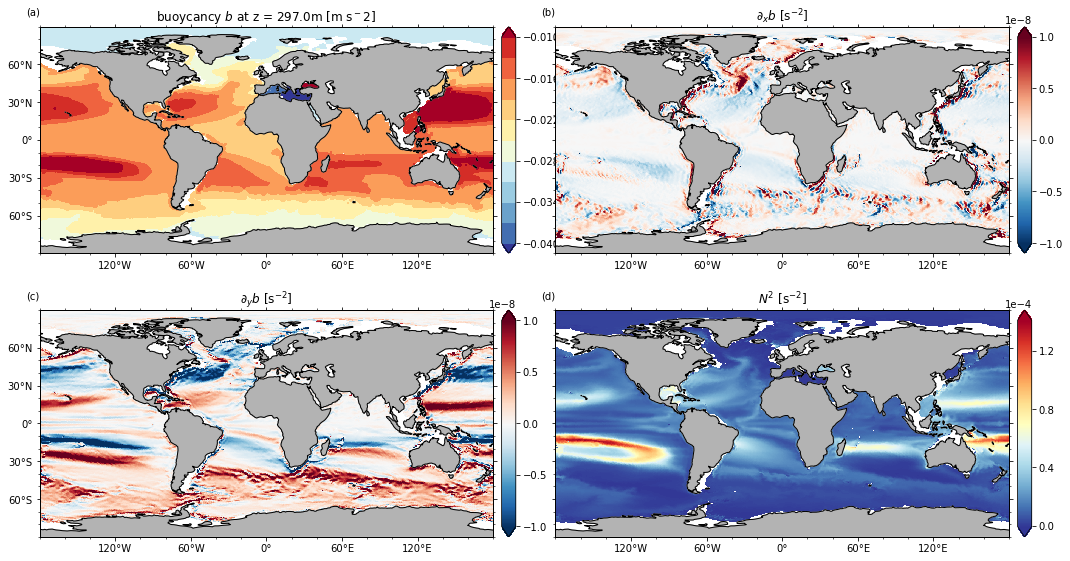

In [19]:
hca, hcb = pyic.arrange_axes(2,2, plot_cb=True, asp=0.5, fig_size_fac=2.,
                               sharex=False, sharey=True, xlabel="", ylabel="",
                               projection=ccrs_proj,
                            )
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, bi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=[-0.04,-0.01], contfs='21' 
               )
ax.set_title(f'buoycancy $b$ at z = {IcD.depthc[iz]:.1f}m [m s$^{-2}$]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, dbdxi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=1e-8, 
               )
ax.set_title('$\partial_x b$ [s$^{-2}$]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, dbdyi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=1e-8, 
               )
ax.set_title('$\partial_y b$ [s$^{-2}$]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, N2vihi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim='auto', 
               )
ax.set_title('$N^2$ [s$^{-2}$]')

for ax in hca:
    pyic.plot_settings(ax, template='global')

Zonal averages:

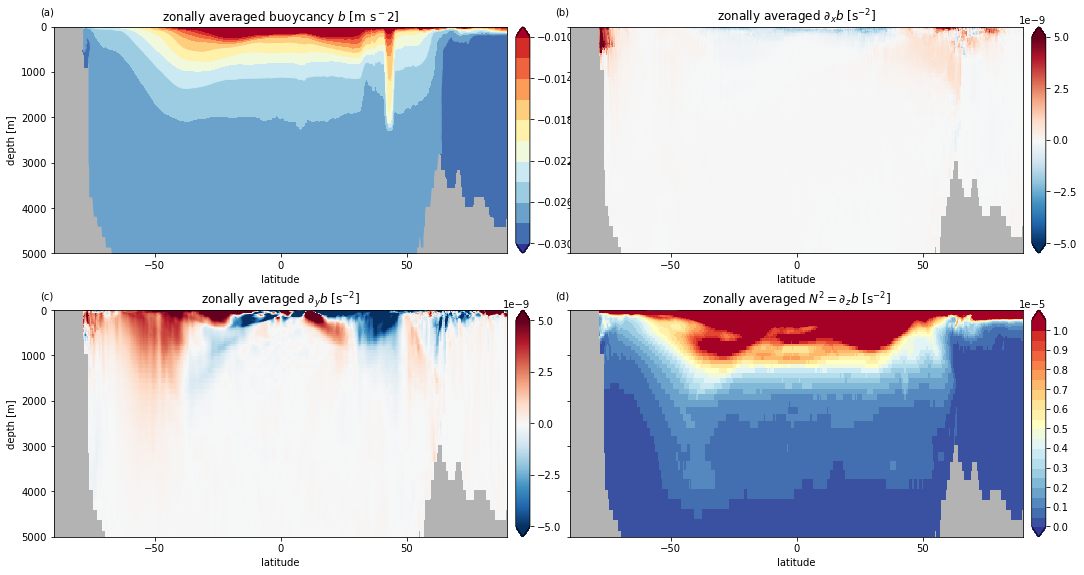

In [20]:
hca, hcb = pyic.arrange_axes(2,2, plot_cb=True, asp=0.5, fig_size_fac=2.,
                               sharex=False, sharey=True, xlabel="latitude", ylabel="depth [m]",
                            )
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lat, IcD.depthc, bi[:,:,:].mean(axis=2), ax=ax, cax=cax,
                clim=[-3e-2,-1e-2], contfs='21' 
               )
ax.set_title(f'zonally averaged buoycancy $b$ [m s$^{-2}$]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lat, IcD.depthc, dbdxi[:,:,:].mean(axis=2), ax=ax, cax=cax,
                clim=5e-9, 
               )
ax.set_title('zonally averaged $\partial_x b$ [s$^{-2}$]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lat, IcD.depthc, dbdyi[:,:,:].mean(axis=2), ax=ax, cax=cax,
                clim=5e-9, 
               )
ax.set_title('zonally averaged $\partial_y b$ [s$^{-2}$]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lat, IcD.depthc, N2vihi[:,:,:].mean(axis=2), ax=ax, cax=cax,
                clim=[0,1e-5], cincr=0.05e-5, 
#                 contfs=np.array([])*1e-5,
               )
ax.set_title('zonally averaged $N^2=\partial_z b$ [s$^{-2}$]')

for ax in hca:
    ax.set_ylim(5000,0)
    ax.set_facecolor('0.7')

## Plot velocity gradients

For plotting, interpolate everything to regular grid:

In [21]:
lon, lat, uoi = pyic.interp_to_rectgrid(uo, fpath_ckdtree, coordinates='clat clon')
lon, lat, dudxi = pyic.interp_to_rectgrid(dudx, fpath_ckdtree, coordinates='clat clon')
lon, lat, dudyi = pyic.interp_to_rectgrid(dudy, fpath_ckdtree, coordinates='clat clon')
lon, lat, dudzi = pyic.interp_to_rectgrid(dudzvi, fpath_ckdtree, coordinates='clat clon')
lon, lat, voi = pyic.interp_to_rectgrid(vo, fpath_ckdtree, coordinates='clat clon')
lon, lat, dvdxi = pyic.interp_to_rectgrid(dvdx, fpath_ckdtree, coordinates='clat clon')
lon, lat, dvdyi = pyic.interp_to_rectgrid(dvdy, fpath_ckdtree, coordinates='clat clon')
lon, lat, dvdzi = pyic.interp_to_rectgrid(dvdzvi, fpath_ckdtree, coordinates='clat clon')

Horizontal plots:

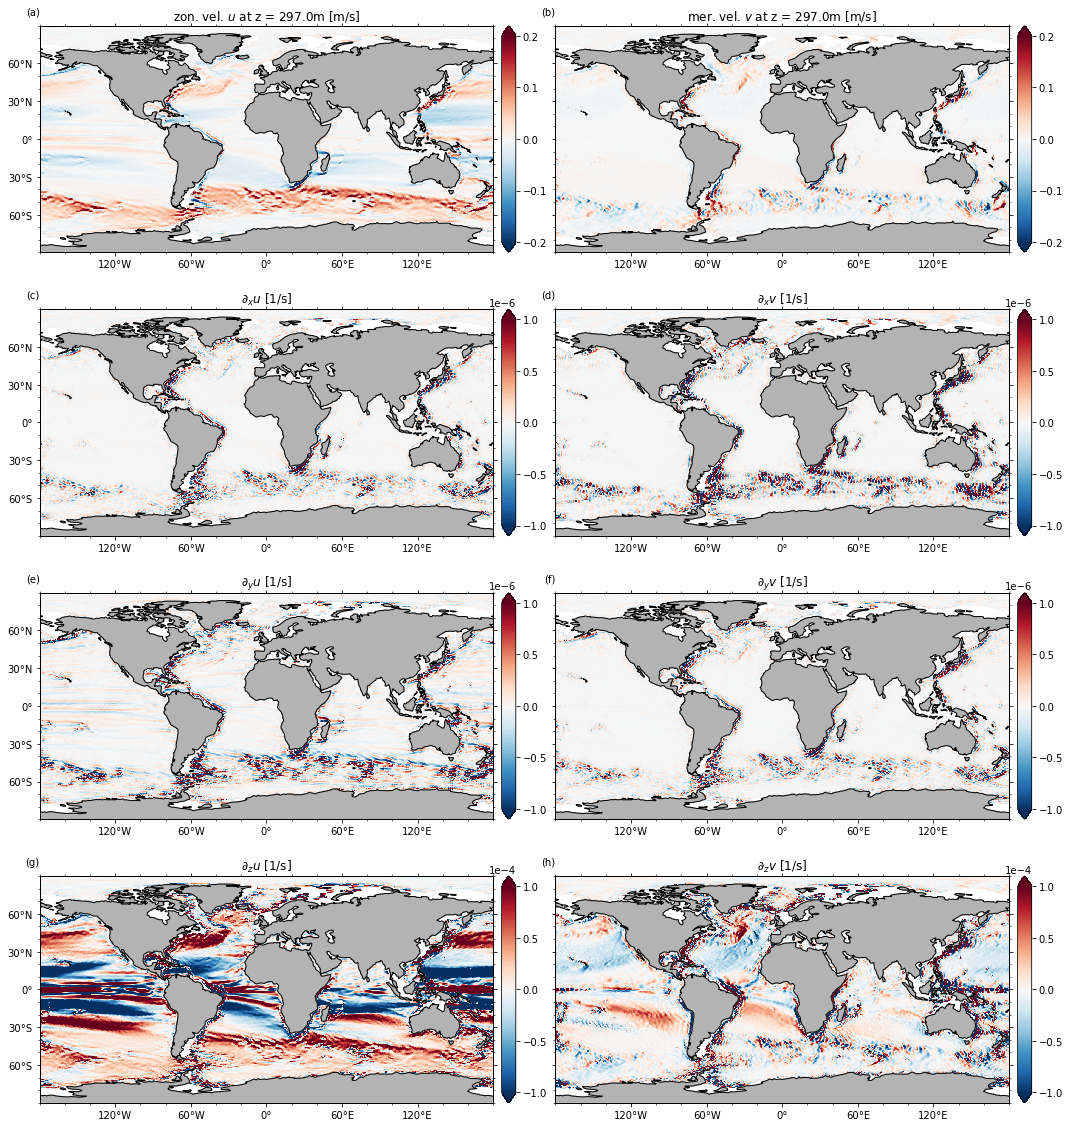

In [22]:
hca, hcb = pyic.arrange_axes(2,4, plot_cb=True, asp=0.5, fig_size_fac=2.,
                               sharex=False, sharey=True, xlabel="", ylabel="",
                               projection=ccrs_proj,
                            )
hca = hca[::2]+hca[1::2]
hcb = hcb[::2]+hcb[1::2]
ii=-1

# --- uo
ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, uoi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=0.2,
               )
ax.set_title(f'zon. vel. $u$ at z = {IcD.depthc[iz]:.1f}m [m/s]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, dudxi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=1e-6, 
               )
ax.set_title('$\partial_x u$ [1/s]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, dudyi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=1e-6, 
               )
ax.set_title('$\partial_y u$ [1/s]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, dudzi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=1e-4, 
               )
ax.set_title('$\partial_z u$ [1/s]')

# --- vo
ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, voi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=0.2,
               )
ax.set_title(f'mer. vel. $v$ at z = {IcD.depthc[iz]:.1f}m [m/s]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, dvdxi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=1e-6, 
               )
ax.set_title('$\partial_x v$ [1/s]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, dvdyi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=1e-6, 
               )
ax.set_title('$\partial_y v$ [1/s]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, dvdzi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=1e-4, 
               )
ax.set_title('$\partial_z v$ [1/s]')


for ax in hca:
    pyic.plot_settings(ax, template='global')